# C14-hepatocyte analysis

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [43]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

mem = joblib.Memory(location='~/tmp/hepato/', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                              filemode='a',
#                              format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                              level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [44]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [45]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

In [46]:
c14.models.liver.global_limit

(0.001, 1000.0)

## Data

In [47]:
data = pd.read_csv('../data/C14data_liver_samples_20191023.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

## Fit the models

In [48]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'],data=edata,step_size=step_size)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'], ignore_physics=True)
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [49]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [50]:
models = c14.models.liver.models_list + [c14.models.minimal.POP1]
models

[c14.models.liver.D,
 c14.models.liver.K,
 c14.models.liver.L,
 c14.models.liver.R,
 c14.models.liver.R2K24,
 c14.models.liver.Dk24lin,
 c14.models.liver.Dr2lin,
 c14.models.minimal.POP1]

In [51]:
init_limit = {'r2': (-3, 0), 
              'r2_0': (-3, 0), 
              'r2_100': (-3, 0), 
              'r4': (-3, 0),
              'lambda2': (-3, 0),
              'lambda4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa24_0': (-3, 0),
              'kappa24_100': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3),
              'lambda_': (-3, 0),
              'r2_0': (-3, 0),
              'r2_1': (-3, 0),
              'r2_100': (-3, 0),
              't_step': (np.log10(5), np.log10(70))
             }

In [52]:
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [53]:
%%time
results = fit_models(edata, models, step_size=2, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=12, 
                                                            init_limit=init_limit)
                    )

CPU times: user 494 ms, sys: 142 µs, total: 495 ms
Wall time: 922 ms


In [54]:
%%time
results = fit_models(edata, models, step_size=0.1, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=12, 
                                                            init_limit=init_limit)
                    )

Fitting model R2K24
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model Dk24lin
[(-3, 0), (-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model Dr2lin
[(-3, 0), (-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model POP1
[(-3, 0)]
CPU times: user 4min 21s, sys: 2.51 s, total: 4min 23s
Wall time: 48min 34s


In [55]:
del results['L']

In [56]:
del results['K']

In [57]:
def summarise(results):
    parameters = pd.concat(
        [result['vis'].get_parameter(result['point_estimate'], 
                                     result['cov'], 
                                     t_eval=[0, 80],
                                     samples=1000,
                                    ignore_physics=True)
         .assign(model = name).reset_index() for name, result in results.items()
        ], ignore_index=True)

    parameters['point_estimate'] = parameters['point_estimate'].astype(float)
    parameters['lower'] = parameters['lower'].astype(float)
    parameters['upper'] = parameters['upper'].astype(float).replace(np.inf, 1e99)
    parameters['parameter'] = parameters['parameter'].astype(str)
    parameters['time'] = parameters['time'].astype(str)

    parameters['ymin'] = parameters['point_estimate'] - parameters['lower']
    parameters['ymax'] = parameters['upper'] - parameters['point_estimate']
    return parameters

In [58]:
parameters = summarise(results)
# parameters_young = summarise(results_young)
# parameters_old = summarise(results_old)

In [84]:
parameters[parameters['lower'] > parameters['point_estimate']]

,time,parameter,point_estimate,lower,upper,model,ymin,ymax


In [83]:
parameters[(parameters['upper'] < parameters['point_estimate'])]

,time,parameter,point_estimate,lower,upper,model,ymin,ymax
66,0,ratio_kappa,32.836638,-0.397787,17.183723,R2K24,33.234425,-15.652915
78,80,ratio_kappa,3.203184,-0.054763,2.309820,R2K24,3.257946,-0.893364


## Parameter Values

### Summarized

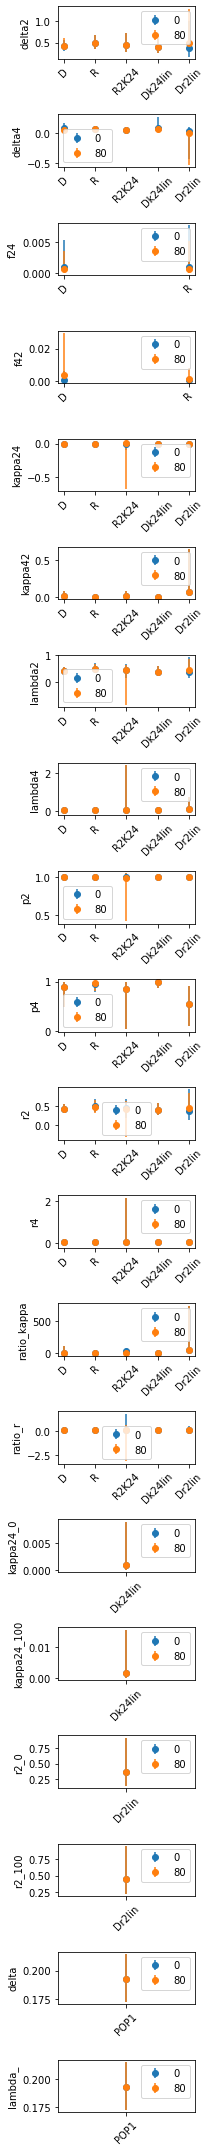

In [175]:
p_names = parameters['parameter'].unique()
# paras = [parameters, parameters_young, parameters_old]

fig, axs = plt.subplots(len(p_names), 1, figsize=(3, 30))



ylimits = {'delta2': (0, 1),
           'p2': (0.5, 1.1),
           'p4': (0.5, 1.1),
           'kappa24': (0, 0.5),
           'kappa42': (0, 1.15),
          'ratio_kappa': (0, 10)}

for parameter, ax in zip(p_names, axs):
    data = parameters[parameters['parameter'] == parameter]
    for time, time_data in data.groupby('time'):
        ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
                    data=time_data, marker='o', ls='None', label=time)
        ax.legend()
        ax.set_ylabel(parameter)
#     try:
#         ax.set_ylim(ylimits[parameter])
#     except:
#         ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

### Detailed

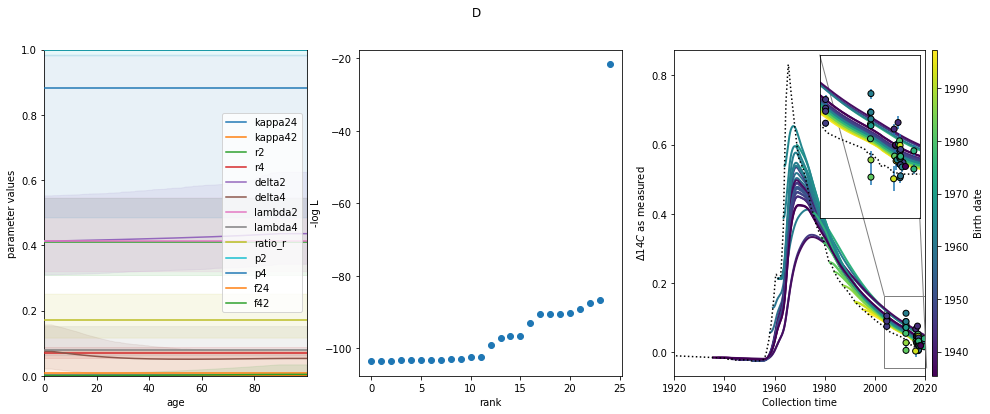

point_estimate        lower       upper
time parameter                                          
0    delta2            0.412937     0.311341    0.553118
     delta4           0.0751874    0.0222417    0.157556
     f24            0.000945885  0.000176344  0.00542657
     f42            0.000768428  8.43172e-05  0.00622798
     kappa24         0.00103002  0.000192031  0.00590929
     kappa42         0.00940696    0.0010322   0.0762418
     lambda2           0.412562     0.320677    0.546945
     lambda4          0.0798296    0.0637006    0.152283
     p2                0.997503     0.981824    0.999638
     p4                0.882162     0.485751    0.984983
     r2                0.411532     0.309267    0.546409
     r4               0.0704226    0.0558812   0.0888853
     ratio_kappa        9.13275     0.502922     118.603
     ratio_r           0.171123     0.117043    0.251714
50   delta2             0.42258     0.325011    0.576626
     delta4           0.0509605  -0.00222455    0.085333
     f24              0.0008113  0.000151253  0.00465445
     f42             0.00199756  0.000219186   0.0161899
     kappa24         0.00103002  0.000192031  0.00590929
     kappa42         0.00940696    0.0010322   0.0762418
     lambda2           0.412562     0.320677    0.546945
     lambda4          0.0798296    0.0637006    0.152283
     p2                0.997503     0.981824    0.999638
     p4                0.882162     0.485751    0.984983
     r2                0.411532     0.309267    0.546409
     r4               0.0704226    0.0558812   0.0888853
     ratio_kappa        9.13275     0.502922     118.603
     ratio_r           0.171123     0.117043    0.251714
80   delta2            0.431765     0.335877    0.602596
     delta4           0.0523382   -0.0076064   0.0775032
     f24            0.000627845  0.000117051  0.00360197
     f42             0.00367301  0.000403028   0.0297691
     kappa24         0.00103002  0.000192031  0.00590929
     kappa42         0.00940696    0.0010322   0.0762418
     lambda2           0.412562     0.320677    0.546945
     lambda4          0.0798296    0.0637006    0.152283
     p2                0.997503     0.981824    0.999638
     p4                0.882162     0.485751    0.984983
     r2                0.411532     0.309267    0.546409
     r4               0.0704226    0.0558812   0.0888853
     ratio_kappa        9.13275     0.502922     118.603
     ratio_r           0.171123     0.117043    0.251714

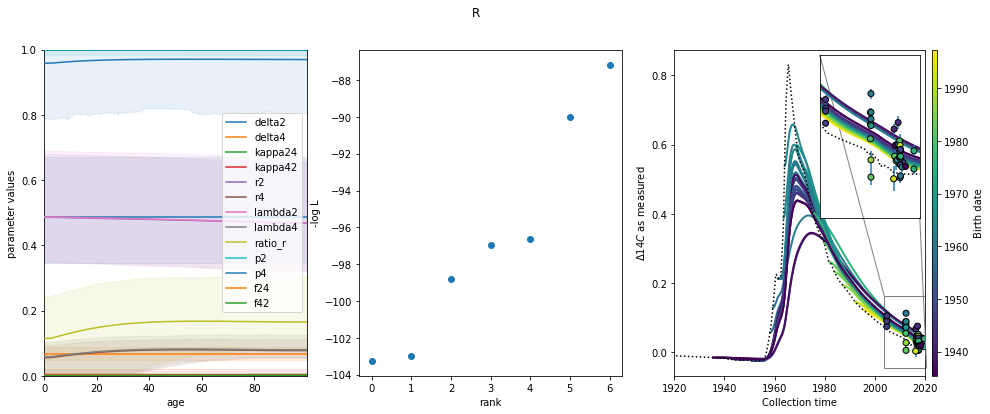

point_estimate        lower       upper
time parameter                                          
0    delta2            0.486868     0.347328    0.669529
     delta4           0.0669913    0.0491734   0.0896802
     f24            0.000921598  9.48791e-05  0.00778454
     f42            0.000197603  1.95544e-05  0.00163754
     kappa24         0.00100358  0.000103319  0.00847701
     kappa42         0.00241902  0.000239382   0.0200464
     lambda2           0.487061     0.350126    0.690147
     lambda4          0.0582523    -0.087075    0.104055
     p2                 0.99794     0.984461    0.999776
     p4                0.958473     0.787847     1.00261
     r2                0.486057     0.348143    0.679727
     r4               0.0558333   -0.0990203   0.0940131
     ratio_kappa         2.4104     0.107501     57.5452
     ratio_r            0.11487    -0.170923    0.244755
50   delta2            0.486868     0.347328    0.669529
     delta4           0.0669913    0.0491734   0.0896802
     f24            0.000790468  8.13792e-05  0.00667692
     f42            0.000513677  5.08325e-05  0.00425684
     kappa24         0.00100358  0.000103319  0.00847701
     kappa42         0.00241902  0.000239382   0.0200464
     lambda2           0.478681     0.339764    0.681323
     lambda4          0.0820807    0.0394055    0.124037
     p2                0.997903     0.984231    0.999777
     p4                0.970529      0.81974    0.999308
     r2                0.477678     0.335034    0.668547
     r4               0.0796617    0.0330938      0.1119
     ratio_kappa         2.4104     0.107501     57.5452
     ratio_r           0.166769    0.0500781    0.301957
80   delta2            0.486868     0.347328    0.669529
     delta4           0.0669913    0.0491734   0.0896802
     f24            0.000611724  6.29774e-05  0.00516711
     f42            0.000944524  9.34682e-05  0.00782726
     kappa24         0.00100358  0.000103319  0.00847701
     kappa42         0.00241902  0.000239382   0.0200464
     lambda2           0.472088     0.326623    0.669696
     lambda4          0.0805894    0.0564898    0.125951
     p2                0.997874     0.983528    0.999776
     p4                0.969983     0.809299    0.998384
     r2                0.471085     0.324598    0.659399
     r4               0.0781704    0.0538507    0.111633
     ratio_kappa         2.4104     0.107501     57.5452
     ratio_r           0.165937    0.0788002    0.305416

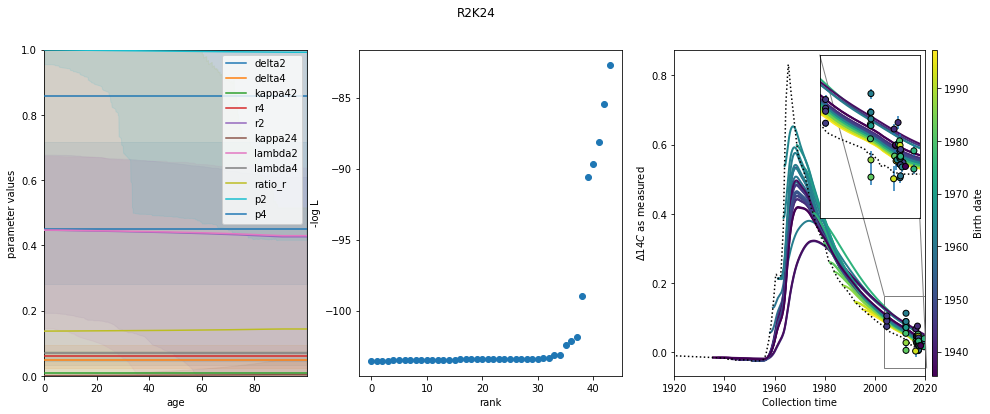

point_estimate        lower       upper
time parameter                                          
0    delta2            0.448566     0.281684    0.716536
     delta4           0.0490222    0.0248634   0.0949778
     kappa24        0.000305204   -0.0937637  0.00520317
     kappa42          0.0100219   0.00111852   0.0752955
     lambda2           0.446686     0.144358    0.672369
     lambda4          0.0711909    0.0315497      2.3979
     p2                0.999317     0.955436     1.05136
     p4                0.859225    0.0451992    0.999004
     r2                0.446381     0.193012    0.678078
     r4                0.061169   0.00208344     2.17727
     ratio_kappa        32.8366    -0.397787     17.1837
     ratio_r           0.137033   0.00054474     1.90412
50   delta2            0.448566     0.281684    0.716536
     delta4           0.0490222    0.0248634   0.0949778
     kappa24         0.00209901    -0.283002   0.0169436
     kappa42          0.0100219   0.00111852   0.0752955
     lambda2            0.44052     -0.16819     0.65438
     lambda4          0.0711909    0.0315497      2.3979
     p2                0.995235     0.488296     1.06304
     p4                0.859225    0.0451992    0.999004
     r2                0.438421    0.0586821    0.651677
     r4                0.061169   0.00208344     2.17727
     ratio_kappa        4.77458    -0.108294     5.27118
     ratio_r           0.139521  9.52013e-05     1.12116
80   delta2            0.448566     0.281684    0.716536
     delta4           0.0490222    0.0248634   0.0949778
     kappa24         0.00312872     -0.67428   0.0383999
     kappa42          0.0100219   0.00111852   0.0752955
     lambda2           0.433166    -0.868747    0.645223
     lambda4          0.0711909    0.0315497      2.3979
     p2                0.992777     0.420136     1.04985
     p4                0.859225    0.0451992    0.999004
     r2                0.430038    -0.315351    0.619187
     r4                0.061169   0.00208344     2.17727
     ratio_kappa        3.20318   -0.0547626     2.30982
     ratio_r           0.142241     -3.21081    0.694918

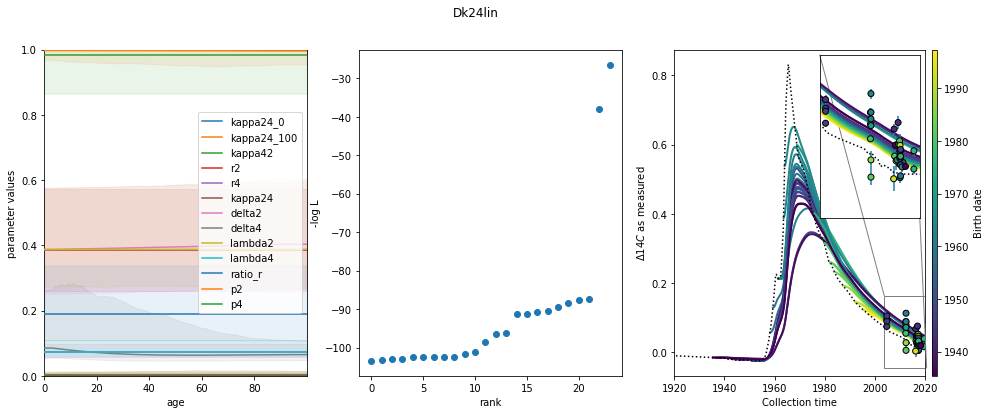

point_estimate        lower      upper
time parameter                                         
0    delta2            0.387163     0.252447   0.576937
     delta4           0.0852635    0.0514361   0.263093
     kappa24         0.00100189  0.000121663  0.0088503
     kappa24_0       0.00100189  0.000121663  0.0088503
     kappa24_100     0.00149838  0.000155533  0.0154533
     kappa42         0.00117814  0.000113719  0.0111638
     lambda2           0.387463     0.273656   0.576409
     lambda4          0.0740808    0.0595274   0.109814
     p2                0.997414     0.970548   0.999762
     p4                0.984097     0.865215   0.998515
     r2                0.386461     0.260295   0.574099
     r4               0.0729027    0.0563063  0.0965336
     ratio_kappa        1.17592    0.0564799    25.0439
     ratio_r           0.188642     0.108717   0.338573
50   delta2             0.39507     0.260697   0.585097
     delta4           0.0633023    0.0465411   0.173337
     kappa24         0.00125013  0.000350517  0.0158177
     kappa24_0       0.00100189  0.000121663  0.0088503
     kappa24_100     0.00149838  0.000155533  0.0154533
     kappa42         0.00117814  0.000113719  0.0111638
     lambda2           0.387711     0.275727   0.585666
     lambda4          0.0740808    0.0595274   0.109814
     p2                0.996776     0.951769   0.999305
     p4                0.984097     0.865215   0.998515
     r2                0.386461     0.260295   0.574099
     r4               0.0729027    0.0563063  0.0965336
     ratio_kappa       0.942411    0.0245941    13.6543
     ratio_r           0.188642     0.108717   0.338573
80   delta2            0.401054     0.262588   0.597847
     delta4           0.0641993    0.0474804   0.115801
     kappa24         0.00139908  0.000307361  0.0166839
     kappa24_0       0.00100189  0.000121663  0.0088503
     kappa24_100     0.00149838  0.000155533  0.0154533
     kappa42         0.00117814  0.000113719  0.0111638
     lambda2            0.38786     0.271439     0.5921
     lambda4          0.0740808    0.0595274   0.109814
     p2                0.996393     0.951819   0.999312
     p4                0.984097     0.865215   0.998515
     r2                0.386461     0.260295   0.574099
     r4               0.0729027    0.0563063  0.0965336
     ratio_kappa        0.84208    0.0243938    14.8067
     ratio_r           0.188642     0.108717   0.338573

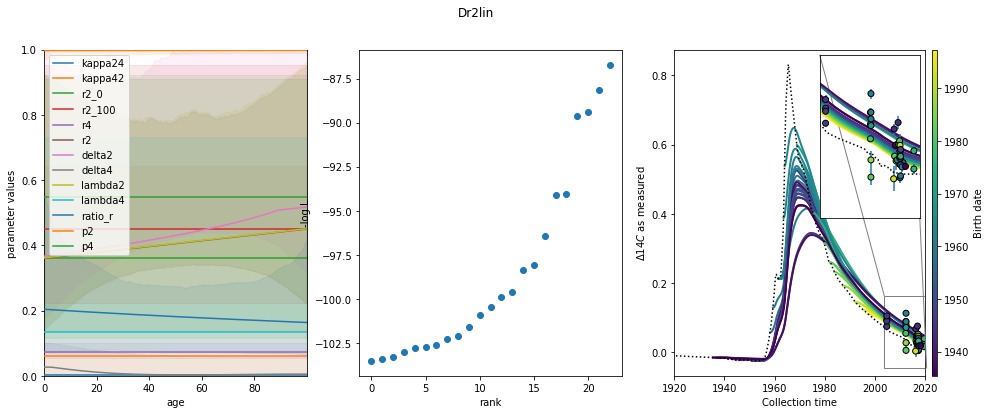

point_estimate        lower       upper
time parameter                                          
0    delta2            0.366647     0.175272     1.00475
     delta4           0.0267079    -0.431055    0.100702
     kappa24         0.00100967  0.000143511  0.00660112
     kappa42           0.060568   0.00664653    0.644421
     lambda2            0.36168     0.149507    0.925007
     lambda4            0.13413    0.0712493    0.731816
     p2                0.997208     0.971762    0.999785
     p4                0.548437     0.116633    0.910003
     r2                 0.36067     0.139739    0.923615
     r2_0               0.36067     0.139739    0.923615
     r2_100            0.450043      0.22231    0.952609
     r4               0.0735618    0.0543383    0.100537
     ratio_kappa        59.9878      4.80081     743.491
     ratio_r           0.203959    0.0727725    0.561789
50   delta2            0.430218      0.42166    0.989849
     delta4          0.00278767    -0.505882   0.0617447
     kappa24         0.00100967  0.000143511  0.00660112
     kappa42           0.060568   0.00664653    0.644421
     lambda2           0.406366     0.341975    0.793252
     lambda4            0.13413    0.0712493    0.731816
     p2                0.997515     0.987247    0.999729
     p4                0.548437     0.116633    0.910003
     r2                0.405357     0.336281    0.782886
     r2_0               0.36067     0.139739    0.923615
     r2_100            0.450043      0.22231    0.952609
     r4               0.0735618    0.0543383    0.100537
     ratio_kappa        59.9878      4.80081     743.491
     ratio_r           0.181474    0.0734475    0.274978
80   delta2            0.485194     0.428209     1.28472
     delta4          0.00425273    -0.527686   0.0574713
     kappa24         0.00100967  0.000143511  0.00660112
     kappa42           0.060568   0.00664653    0.644421
     lambda2           0.433178     0.321321    0.843245
     lambda4            0.13413    0.0712493    0.731816
     p2                0.997669     0.988656    0.999671
     p4                0.548437     0.116633    0.910003
     r2                0.432168     0.319899    0.835872
     r2_0               0.36067     0.139739    0.923615
     r2_100            0.450043      0.22231    0.952609
     r4               0.0735618    0.0543383    0.100537
     ratio_kappa        59.9878      4.80081     743.491
     ratio_r           0.170216    0.0704399    0.289585

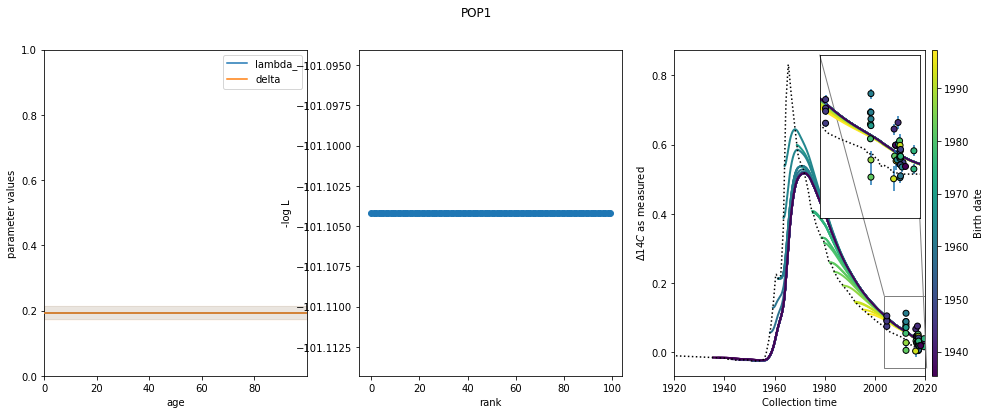

point_estimate     lower     upper
time parameter                                   
0    delta           0.192405  0.172837  0.214571
     lambda_         0.192405  0.172837  0.214571
50   delta           0.192405  0.172837  0.214571
     lambda_         0.192405  0.172837  0.214571
80   delta           0.192405  0.172837  0.214571
     lambda_         0.192405  0.172837  0.214571

In [60]:
for name, result in results.items():
    if name not in ['']:
        no_plot = ['ratio_kappa']
        fig, axs = plt.subplots(1, 3, figsize=(16,6))
        fig.suptitle(name)
        result['vis'].plot_parameter(result['point_estimate'], result['errors'],
                                         no_plot=no_plot, axis=axs[0])
#         result['vis'].plot_parameter(result['point_estimate'], 
#                                          no_plot=no_plot, axis=axs[0])

        axs[0].legend()
        axs[0].set_ylabel('parameter values')
        axs[0].set_ylim(0, 1)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('-log L')
    #         axs[1].set_xlim(0, 100)
        
        _ = result['vis'].odeint()
        result['vis'].plot_simdata( axis=axs[2], cmap=plt.cm.viridis)
        axs[2].set_xlim(1920, 2020)

        plt.show()

        try:
            display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 50, 80], ignore_physics=True
                                               ))
        except:
            pass

## Export

In [61]:
# model = 'A'

# time = np.linspace(0, 100, 101)
# df = pd.DataFrame(results[model]['model'].get_implicit_parameters(time))[['r2', 'kappa24', 'ratio_r', 'p']]
# # df.columns=['r2', 'r4', 'kappa24', 'kappa42', 'ratio_r']
# df['r4'] = results[model]['model'].r4
# df['kappa42'] = results[model]['model'].kappa42
# df['delta2'] = results[model]['model'].delta2
# df['delta4'] = results[model]['model'].delta4
# df['age'] = time
# df['ploidy'] = c14.models.liver.A().ploidy(df['age'])
# df.head()

# result = results[model]
# df = result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=time).unstack().reset_index()

# df = df[['time', 'point_estimate']]

# df.to_excel('../../../results/parameters_A.xlsx')

## Model selection

In [62]:
_ = results.pop('POP1', None)

In [63]:
model_selection_results = pd.DataFrame(
    pd.Series(
        {name: result['op'].calc_aicc(result['point_estimate'])
         for name, result in results.items()}, name='cAIC'))
model_selection_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for name, result in results.items()]
model_selection_results['nparas'] = [result['model'].nparas for name, result in results.items()] 
model_selection_results['nparas'] += 1
model_selection_results = pd.DataFrame(model_selection_results)
model_selection_results['delta'] = model_selection_results['cAIC'] - model_selection_results['cAIC'].min() 
model_selection_results['w'] = np.exp(-0.5*model_selection_results['delta']) / np.exp(-0.5*model_selection_results['delta']).sum()
model_selection_results['ER'] = model_selection_results['w'].max() / model_selection_results['w']
model_selection_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
R2K24,-195.367658,103.540972,5,0.000000,0.313795,1.000000
D,-195.285997,103.500141,5,0.081661,0.301241,1.041675
R,-194.778993,103.246640,5,0.588664,0.233786,1.342230
Dr2lin,-192.545035,103.507812,6,2.822623,0.076511,4.101330
Dk24lin,-192.496265,103.483426,6,2.871393,0.074667,4.202572


In [64]:
# parameters = parameters.merge(model_selection_results, left_on='model', right_index=True)

In [65]:
# parameters['log10_point_estimate'] = np.log10(parameters['point_estimate'])
# parameters['log10_lower'] = np.log10(parameters['lower'])
# parameters['log10_upper'] = np.log10(parameters['upper'])
# parameters.head()

# parameters['log10_error_lower'] = parameters['log10_point_estimate'] - parameters['log10_lower']
# parameters['log10_error_upper'] = -parameters['log10_point_estimate'] + parameters['log10_upper']

# parameters['log10_error'] = parameters[['log10_error_lower', 'log10_error_upper']].mean(axis='columns')

# parameters.head()

# def parameter_average(data):
#     parameter = data['parameter'].iloc[0]
#     log10_mean = np.average(data['log10_point_estimate'], weights=data['w'])
#     log10_error = np.average(
#         np.sqrt(data['log10_error']**2 + (data['log10_point_estimate'] - log10_mean)**2),
#         weights=data['w'])
#     point_estimate = 10**log10_mean
#     lower = 10**(log10_mean-log10_error)
#     upper = 10**(log10_mean+log10_error)
#     return pd.Series({
#         'point_estimate': point_estimate,
#         'lower': lower,
#         'upper': upper,
#         'model': 'average',
#         'ymin': point_estimate - lower,
#         'ymax': point_estimate + upper,
#         'log10_point_estimate': log10_mean,
#         'log10_error': log10_error
#     })

# rates = ["r2", "r4", "delta2", "delta4", "kappa24", "kappa42", "lambda2", "lambda4"]

# averaged_parameters = (parameters
#                        .query('parameter in @rates')
#                        .groupby(['time', 'parameter'])
#                        .apply(parameter_average)
#                        .reset_index()
#                         )

In [66]:
# parameters = pd.concat([parameters, averaged_parameters], axis='rows', sort=False)

In [67]:
# p_names = parameters['parameter'].unique()
# paras = 3*[parameters]
# fig, axss = plt.subplots(len(p_names), len(paras), figsize=(9, 30))



# ylimits = {'delta2': (0, 2),
#            'delta4': (0, 1),
#            'lambda2': (0, 2),
#            'r2': (0, 2),
#            'p2': (0.5, 1.1),
#            'p4': (0.5, 1.1),
#            'kappa24': (0, 0.2),
#           'ratio_kappa': (0, 10)}

# for parameter, axs in zip(p_names, axss):
#     for para, ax in zip(paras, axs):
#         data = para[para['parameter'] == parameter]
#         for time, time_data in data.groupby('time'):
#             ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
#                         data=time_data, marker='o', ls='None', label=time)
#             ax.legend()
#             ax.set_ylabel(parameter)
#         try:
#             ax.set_ylim(ylimits[parameter])
#         except:
#             ax.set_ylim(0, 1)
#         ax.tick_params(axis='x', labelrotation=45)

# plt.tight_layout()
# plt.show()

## Profile Likelihood

In [68]:
m = c14.models.liver.R()

In [69]:
op = c14.optimize(m, edata, step_size=0.1)

In [70]:
p0 = results['R']['multistart_result'].iloc[0]['values']

In [71]:
def nloglike_R(delta2, delta4, kappa24, kappa42):
    return -op.loglike_dict({'delta2': delta2, 'delta4': delta4, 'kappa24': kappa24, 'kappa42': kappa42}, m)

In [72]:
import iminuit

In [73]:
M = iminuit.Minuit(nloglike_R,
               delta2=p0['delta2'], error_delta2=0.01, 
               delta4=p0['delta4'], error_delta4=0.01,
               kappa24=p0['kappa24'], error_kappa24=0.01,
               kappa42=p0['kappa42'], error_kappa42=0.01,
               errordef=0.5,
                   pedantic=False
              )

In [74]:
_ = M.migrad()

FCN = -103.40252631787904 
 TOTAL NCALL = 179 
 NCALLS = 179 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,delta2,-0.312589,nan,,,,,No
1,delta4,-1.17398,nan,,,,,No
2,kappa24,-2.47527,nan,,,,,No
3,kappa42,-2.61636,nan,,,,,No


In [75]:
M.minos()

Error,nan,nan
Valid,False,False
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,nan,nan
Valid,False,False
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,nan,nan
Valid,False,False
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,nan,nan
Valid,False,False
At Limit,False,False
Max FCN,False,False
New Min,False,False


{'delta2': {'lower': nan,
  'upper': nan,
  'is_valid': False,
  'lower_valid': False,
  'upper_valid': False,
  'at_lower_limit': False,
  'at_upper_limit': False,
  'at_lower_max_fcn': False,
  'at_upper_max_fcn': False,
  'lower_new_min': False,
  'upper_new_min': False,
  'nfcn': 1152,
  'min': -0.31258881105848946},
 'delta4': {'lower': nan,
  'upper': nan,
  'is_valid': False,
  'lower_valid': False,
  'upper_valid': False,
  'at_lower_limit': False,
  'at_upper_limit': False,
  'at_lower_max_fcn': False,
  'at_upper_max_fcn': False,
  'lower_new_min': False,
  'upper_new_min': False,
  'nfcn': 1152,
  'min': -1.1739814192405453},
 'kappa24': {'lower': nan,
  'upper': nan,
  'is_valid': False,
  'lower_valid': False,
  'upper_valid': False,
  'at_lower_limit': False,
  'at_upper_limit': False,
  'at_lower_max_fcn': False,
  'at_upper_max_fcn': False,
  'lower_new_min': False,
  'upper_new_min': False,
  'nfcn': 1152,
  'min': -2.4752725507500717},
 'kappa42': {'lower': nan,
  'up